Credits goes to
https://github.com/NielsRogge/Transformers-Tutorials/tree/master/TrOCR<br>
https://arxiv.org/abs/2109.10282
TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models
<br>
https://huggingface.co/aubmindlab/bert-base-arabert

<br>
https://huggingface.co/xlm-roberta-base


In [ ]:
!pip install transformers
!pip install datasets
!pip install torchvision
!pip install "accelerate>=0.20.1"
!pip install accelerate -U
!pip install datasets
!pip install jiwer


# Libraries
# Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
#from scipy.sparse import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import Trainer

# Data

In [5]:
dff = pd.read_csv("/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/clean_images.csv",index_col=None)

In [6]:
# Rename the "imagename" column to "file name"
dff.rename(columns={'ImageName': 'file_name'}, inplace=True)
dff.rename(columns={'TextContent': "text"}, inplace=True)
# reduce the data size due to limited RAM and time
df=dff.sample(n=2000, random_state=42)

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3 ,random_state=42)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

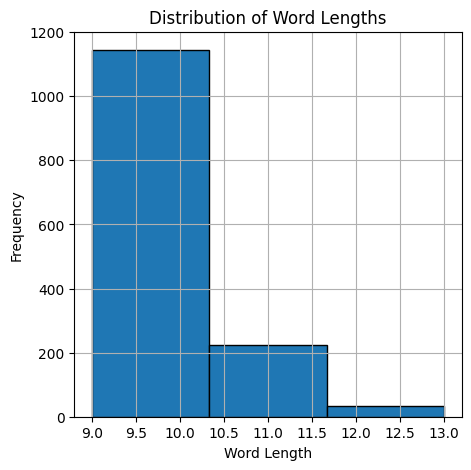

In [8]:
# Convert the 'textcontent' column to string
train_df['text'] = train_df['text'].astype(str)
# Calculate the length of words in the 'textcontent' column
word_lengths = train_df['text'].apply(lambda x: len(x.split()))

# Plot a histogram
plt.figure(figsize=(5, 5))
plt.hist(word_lengths, bins=3, edgecolor='black')
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# data consentrated around  9 to 13 tokens

Pytorch data Class

In [9]:
# max target legth = 20 to buffer for subword level tokenizer used by Transformers
class IAMDataset(Dataset):

    def __init__(self, root_dir, df, processor, max_target_length=20):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length",max_length=self.max_target_length).input_ids[:self.max_target_length]
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

# Model

In [10]:
# choosing feature extractor and tokenizer
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
#decoder_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabert")
# using multilingual roberta fine tuned on arabic is better
decoder_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')


processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:45: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


In [11]:
processor.save_pretrained('./processor')

In [12]:
processor = TrOCRProcessor.from_pretrained("./processor")
datadir="/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/filtered_images/"
train_dataset = IAMDataset(root_dir=datadir ,df=train_df,processor=processor)
eval_dataset = IAMDataset(root_dir= datadir ,df=test_df,processor=processor)

In [13]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1400
Number of validation examples: 600


In [14]:
encoding = train_dataset[5]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([20])


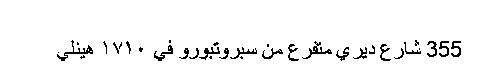

In [15]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][5]).convert("RGB")
image

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

355 شارع ديري متفرع من سبروتبورو في ١٧١٠ 


In [17]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-384", 'xlm-roberta-base')
# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
# make max_length = 20
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.8.crossattention.output.dense.weight', 'roberta.encoder.layer.7.crossattention.self.key.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.11.crossattention.self.key.bias', 'roberta.encoder.layer.7.crossattention.self.key.weight', 'roberta.encoder.layer.7.crossattention.self.query.bias', 'roberta.encoder.layer.3.crossattention.self.key.bias', 'roberta.encoder.layer.6.crossattention.self.key.bias', 'roberta.encoder.layer.1.crossattention.self.v

In [18]:

# Define the training arguments for the Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,  # Enable generation mode during evaluation
    evaluation_strategy="epoch",  # Strategy for when to evaluate the model during training
    per_device_train_batch_size=3,  # Batch size for training data (per device)
    per_device_eval_batch_size=3,   # Batch size for evaluation data (per device)
    fp16= False,  # Enable mixed-precision training for faster training on supported GPUs
    output_dir="/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data",  # Directory to save checkpoints and logs
    logging_steps=2,  # Log metrics every specified number of training steps
    save_steps=20,  # Save model checkpoint every specified number of steps
    eval_steps=200,   # Evaluate model every specified number of steps during training
    num_train_epochs=3,  # Total number of training epochs
    )


In [19]:
from datasets import load_metric
cer_metric = load_metric("cer")

<ipython-input-19-6424484073b5>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:



# Load the checkpointed model
model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/checkpoint-520')



from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    #tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train(resume_from_checkpoint=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Epoch,Training Loss,Validation Loss


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss


In [ ]:
trainer.save_model('/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/trainer')

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/trainer')

In [ ]:
image = Image.open("/content/drive/MyDrive/OCR_BLNK/OCR_DATA/samples_images/0.jpg").convert("RGB")

pixel_values = processor.feature_extractor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

In [ ]:
model.save_pretrained('/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/trainer')

# Convert to ONNX

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel
from transformers import AutoFeatureExtractor, AutoProcessor

# Load the checkpointed model
model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/OCR_BLNK/OCR_DATA/unziped_data/trainer')


# Load the feature extractor and processor
feature_extractor = = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
decoder_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)
# Create dummy input
batch_size = 3  # Replace with your batch size
channels = 3    # Replace with the number of image channels (e.g., 3 for RGB)
height = 384    # Replace with your image height
width = 384     # Replace with your image width
max_seq_length = 20  # Replace with your maximum sequence length

dummy_image_input = torch.randn(batch_size, channels, height, width)
dummy_text_input = torch.randint(0, processor.tokenizer.vocab_size, (batch_size, max_seq_length))

# Run the model's forward pass (without training)
with torch.no_grad():
    outputs = model(pixel_values=dummy_image_input, input_ids=dummy_text_input)

# Export the core model to ONNX
onnx_path = "path_to_save/model.onnx"  # Replace with your desired path
torch.onnx.export(
    model,
    (dummy_image_input, dummy_text_input),
    onnx_path,
    verbose=True,
    input_names=["pixel_values", "input_ids"],
    output_names=["logits"],
)

print("Model exported to ONNX:", onnx_path)


# Convert to TRT

In [ ]:
import tensorrt as trt

# Initialize TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.INFO)
trt_runtime = trt.Runtime(TRT_LOGGER)

# Load the ONNX model
onnx_path = 'model.onnx'
onnx_model = onnx.load(onnx_path)

# Create a TensorRT builder and network
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network()

# Parse the ONNX model into the TensorRT network
parser = trt.OnnxParser(network, TRT_LOGGER)
success = parser.parse(onnx_model.SerializeToString())

# Build an optimized TensorRT engine
engine = builder.build_cuda_engine(network)

# Save the TensorRT engine
trt_path = 'model_trt.engine'
with open(trt_path, 'wb') as f:
    f.write(engine.serialize())
